In [1]:
import torch 
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch import optim

import torch.nn.functional as F
torch.__version__


'1.8.1+cu101'

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
  available_device= "cuda" if torch.cuda.is_available() else "cpu"
  device = torch.device(available_device)
  print(device)

cuda


In [4]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Loading MNIST dataset

In [5]:
transform = transforms.ToTensor()

train_set = datasets.MNIST(root="pytorch_dataset/",
                           train=True,
                           download=True,
                           transform=transform)

test_set = datasets.MNIST(root="pytorch_dataset/",
                          train=False,
                          download=True,
                          transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting pytorch_dataset/MNIST/raw/train-images-idx3-ubyte.gz to pytorch_dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting pytorch_dataset/MNIST/raw/train-labels-idx1-ubyte.gz to pytorch_dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting pytorch_dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to pytorch_dataset/MNIST/raw




Extracting pytorch_dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to pytorch_dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Dataloader

In [6]:
batch_size = 64
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_set,
                        batch_size=batch_size,
                        shuffle=True)
print("Data loaded")

Data loaded


In [7]:
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


## Show the batch

In [8]:
def show_grid_tensor(grid_im, n, c=None):
    fig = plt.figure(figsize=(15,15))
    for i in range(n):
        ax = plt.subplot(8, 8, i+1)
        plt.imshow(grid_im[i], cmap=c)
        plt.axis("off")
        # ax.set_title(f"activation {i}")
    return plt

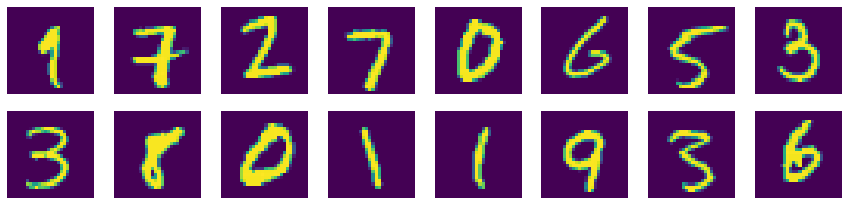

In [9]:
x_reverse = x.reshape(-1, 28, 28)
ax1 = show_grid_tensor(x_reverse, 16)
ax1.show()

## Prepare the model architecture

In [10]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
    
    def forward(self, x):
        x = x.view(self.shape)
        return x

class Trim(nn.Module):
    def __init__(self, *args):
        super(Trim, self).__init__()
    
    def forward(self, x):
        return x[:, :, :28, :28]

In [11]:
class VAE_MNIST(nn.Module):
    def __init__(self, in_channels=1, encoding_dims=2, batch_size=64):
        super(VAE_MNIST, self,).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.LeakyReLU(0.01),
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.01),
            
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.01),
            
            nn.Conv2d(64, 64, 3, padding=1),
            nn.Flatten(),
        )

        self.z_mean = nn.Linear(3136, encoding_dims)
        self.z_log_var = nn.Linear(3136, encoding_dims)

        self.decoder = nn.Sequential(
            nn.Linear(encoding_dims, 3136),
            Reshape(-1, batch_size, 7, 7),
            
            nn.ConvTranspose2d(64, 64, 3, padding=1),
            nn.LeakyReLU(0.01),
            
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.01),

            nn.ConvTranspose2d(64, 32, 3, stride=2),
            nn.LeakyReLU(0.01),
            
            nn.ConvTranspose2d(32, 1, 3),

            Trim(),
            nn.Sigmoid(), # 0 to 1
        )

    def reparameterize(self, x, z_mu, z_log_var):
        # z = mu + x * var
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.)
        return z

    def encoding_fn(self, x):
        x =  self.encoder(x)

        z_mu = self.z_mean(x)
        z_log_var = self.z_log_var(x)    
        # get z using mean and var
        encoded = self.reparameterize(x, z_mu, z_log_var)
        return encoded

    def forward(self, x):
        x =  self.encoder(x)

        z_mu = self.z_mean(x)
        z_log_var = self.z_log_var(x)
            
        # get z using mean and var
        encoded = self.reparameterize(x, z_mu, z_log_var)

        decoded = self.decoder(encoded)

        return encoded, z_mu , z_log_var, decoded

### Initialize the model 

In [12]:
model = VAE_MNIST(in_channels=1, 
                  encoding_dims=2,
                  batch_size=batch_size).to(device)

## Optimizer

In [13]:
LEARNING_RATE = 0.005
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Loss Functions 
- total loss = reconstruction loss + KL divergence

In [14]:
def reconstrucion_loss(x, y, batch_size):
    """
        Reconstruction loss, original image vs decoded image loss
        1st calculte the pixel wise mse 
        then sum for single image 
        and finally mean for all the iamges in the batch
    """
    pixel_wise = F.mse_loss(x, y, reduction='none')
    pixel_wise = pixel_wise.view(batch_size, -1).sum(axis=1)

    return pixel_wise.mean()

def kl_divergence(z_mu, z_log_var):
    """

    """
    kl_div = -0.5 * torch.sum(1 + z_log_var - z_mu**2 - torch.exp(z_log_var), 
                              axis=1) # sum over latent dimension
    return kl_div.mean()


In [ ]:
a = torch.randn(3, 5)
b = torch.randn(3, 5)

pixel_wise = F.mse_loss(a, b, reduction='none')
pixel_wise.shape

torch.Size([3, 5])

In [ ]:
pixel_wise = pixel_wise.view(3, -1).sum(axis=1) # sum over pixels

In [ ]:
pixel_wise = pixel_wise.mean()
pixel_wise

tensor(9.2413)

In [ ]:
reconstrucion_loss(a, b, 3, reconstruction_weight=1)

tensor(9.2413)

## Train the model 

In [15]:
from tqdm.notebook import tqdm

In [16]:
reconstruction_weight=1 

In [24]:
NUM_EPOCHS =  50
for epoch in range(NUM_EPOCHS):
    loop = tqdm(train_loader,
            total=len(train_loader),
            leave=True)
    model.train()
    for x, labels in loop:
        x = x.to(device)

        optimizer.zero_grad()

        encoded, z_mu , z_log_var, decoded_x = model(x)

        rl = reconstrucion_loss(x, 
                                decoded_x, 
                                x.size(0))
        
        kl_d = kl_divergence(z_mu, z_log_var)

        loss = rl * reconstruction_weight + kl_d
        loss.backward()

        optimizer.step()
        
        loop.set_description(f"Epoch [{epoch + 1}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss.item(), 
                         rl_loss=rl.item(), 
                         kl_div=kl_d.item())
        # break

print("Done training")      


Done training


## Looking in the test set

In [18]:
for x_test, _ in test_loader:
    print(x_test.shape)
    break

torch.Size([64, 1, 28, 28])


In [25]:
model.eval()   
# x_test_d = x_test.
encoded, z_mu , z_log_var, decoded_x = model(x_test.to(device))

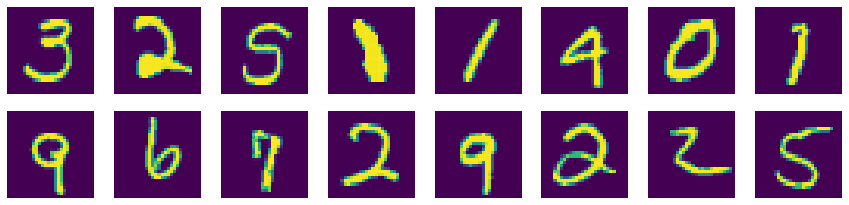

In [26]:
x_reverse = x_test.reshape(-1, 28, 28)
ax1 = show_grid_tensor(x_reverse, 16)

ax1.show()

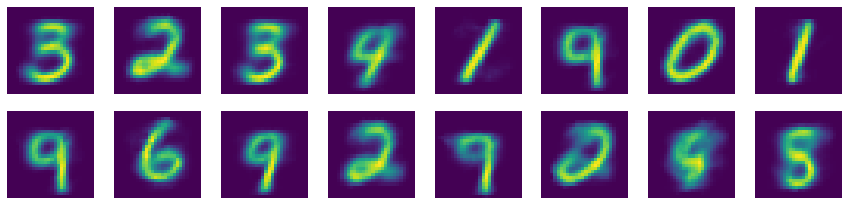

In [27]:
x_reverse = decoded_x.to('cpu').detach().reshape(-1, 28, 28)
ax1 = show_grid_tensor(x_reverse, 16)
ax1.show()

In [22]:
!nvidia-smi

Fri May 14 14:36:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    34W /  70W |   1126MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [34]:
model.eval()  
x_test, label = next(iter(test_loader))

encoded, z_mu , z_log_var, decoded_x = model(x_test.to(device))
encodings = encoded.to('cpu').detach().numpy()
labels = label.numpy()
for x_test, label in test_loader:
# x_test_d = x_test.
    encoded, z_mu , z_log_var, decoded_x = model(x_test.to(device))
    np_encoded = encoded.to('cpu').detach().numpy()
    encodings = np.concatenate((encodings, np_encoded), axis=0)
    labels = np.concatenate((labels, label), axis=0)
    # break
print(encodings.shape)
print(labels.shape)

(10064, 2)
(10064,)


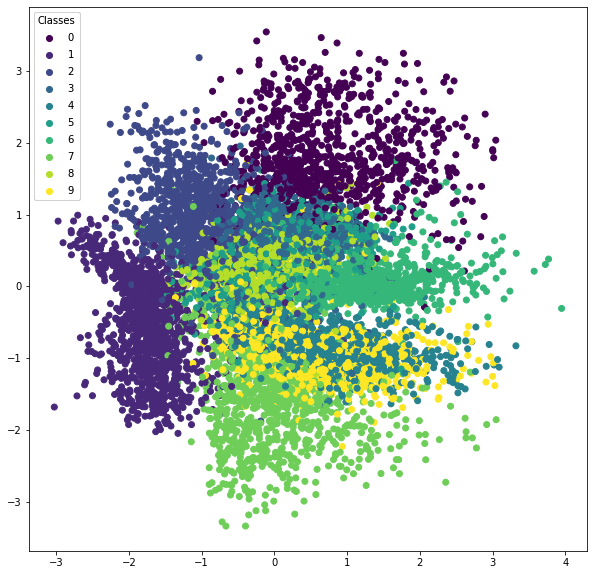

In [46]:
fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(encodings[:,0], encodings[:,1], c=labels)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)

plt.show()

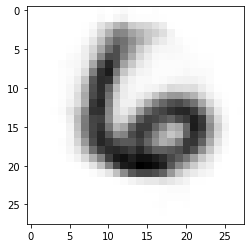

In [43]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([2.0, 0]).to(device))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()